In [283]:
from matplotlib import pyplot as plt, colors
import numpy as np
import pandas as pd
import six
from sklearn.cluster import DBSCAN, k_means
from sklearn import metrics

%matplotlib inline

In [17]:
data = pd.read_csv("./data/data.txt", sep=' ', header=None)

In [18]:
data.head()

,0,1
0,68.601997,102.491997
1,454.665985,264.808990
2,101.283997,169.285995
3,372.614990,263.140991
4,300.989014,46.555000


In [19]:
data.describe()

,0,1
count,8000.000000,8000.000000
mean,317.714405,157.282188
std,157.996523,73.653055
min,14.642000,21.381001
25%,185.740249,87.291250
50%,323.467987,152.741996
75%,454.817513,217.054497
max,634.956970,320.873993


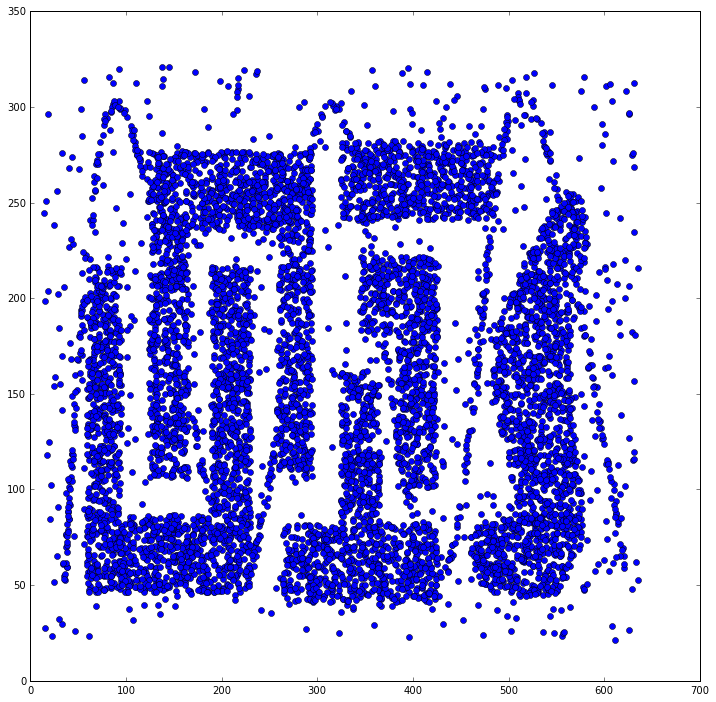

In [23]:
plt.figure(figsize=(12, 12))
plt.plot(data[0].values, data[1].values, 'bo')

In [107]:
def nn_distance(point, arr):
    """
    returns the distance between the point given and the closest point from the array given
    point: 1d numpy.array
    arr: 2d numpy.array, points array
    """
    assert len(point.shape) == 1 and len(arr.shape) == 2
    assert point.shape[0] == arr.shape[1]
    distances = np.sqrt(np.sum((arr - point) ** 2, axis=1))
    return np.min(distances[distances != 0])

For uniform distribution
$$\mu = \frac{b + a}{2}$$
$$\sigma^2 = \frac{(b-a)^2}{12}$$
Therefore:
$$b = 2\mu - a$$
$$\sigma^2 = \frac{(\mu - a)^2}{3}$$
$$\sqrt{3\sigma^2} = \mu - a$$
So:
$$a = \mu-\sqrt{3\sigma^2}$$
$$b = 2\mu - a$$

In [161]:
def hopkins_statistic(n, arr):
    """
    Assesses irregularity of the dataset
    
    Algorithm taken from: 
    http://www.sthda.com/english/wiki/assessing-clustering-tendency-a-vital-issue-unsupervised-machine-learning
    
    n: int, amount of points to draw from distributions
    arr: 2d numpy.array, points array
    """
    assert isinstance(n, int)
    assert len(arr.shape) == 2
    arr_mean = np.mean(arr, axis=0)  # (b + a) / 2
    arr_std = np.std(arr, axis=0)    # 1/12 (b - a)^2

    a = arr_mean - np.sqrt(3) * arr_std
    b = 2 * arr_mean - a

    D = arr[np.random.choice(range(len(arr)), n), :]
    D_qi = np.random.uniform(size=(n, 2)) * [b[0] - a[0], b[1] - a[1]] + [a[0], a[1]]

    D_nn = map(lambda p: nn_distance(p, D), D)
    D_qi_nn = map(lambda p: nn_distance(p, D_qi), D_qi)
    
    # Let's plot two comparing sets of points:
    plt.figure(figsize=(12, 8))
    ax1 = plt.subplot(1, 2, 1)
    plt.plot(D[:, 0], D[:, 1], 'bo')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    plt.plot(D_qi[:, 0], D_qi[:, 1], 'bo')

    return sum(D_qi_nn) / (sum(D_nn) + sum(D_qi_nn))

In [171]:
def hopkins_statistic_(n, arr):
    """
    Slightly different method of dataset irregularity assessment taken from Han, Data Mining Concepts and Techniques
    
    n: int, amount of points to draw from distributions
    arr: 2d numpy.array, points array
    """
    assert isinstance(n, int)
    assert len(arr.shape) == 2
    
    D = arr[np.random.choice(range(len(arr)), n)]
    choice = np.random.choice(range(len(arr)), n)
    inv_choice = np.array([i for i in range(len(arr)) if i not in choice])
    D_qi = arr[inv_choice, :]
    
    D_nn = map(lambda p: nn_distance(p, D), D)
    D_qi_nn = map(lambda p: nn_distance(p, D_qi), arr[choice, :])
    
    return sum(D_qi_nn) / (sum(D_nn) + sum(D_qi_nn))

1.11279392099
0.355140261069


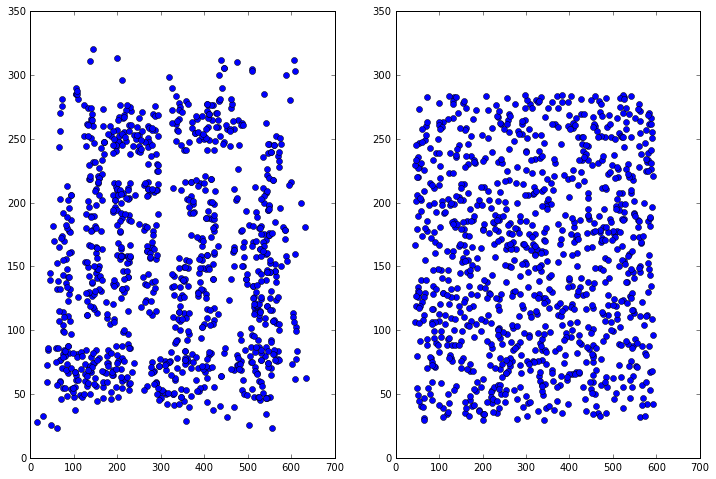

In [172]:
print(hopkins_statistic(1000, data.values))
print(hopkins_statistic_(1000, data.values))

This two values are far from 0.5, so we can conclude that data are definitely clustered.

#### Let's use elbow method so as to find optimal value of k in kmeans

In [187]:
results = []
for k in range(1, 21):
    results.append(k_means(data.values, k)[2])
results = np.array(results)

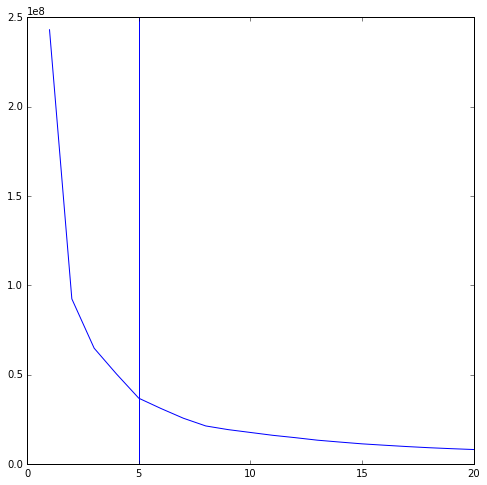

In [191]:
plt.figure(figsize=(8, 8))
plt.plot(np.arange(1, 21), results)
plt.axvline(5)

Let's use 5 as the optimal parameter for k-means

In [313]:
def execute_dbscan(eps=1, min_samples=15, plot_=False, silhouette=True):
    cl = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = cl.fit_predict(data) + 1 # So as to get rid of '-1' class
    clusters_count = np.unique(clusters).shape[0]
    colors_ = list(six.iteritems(colors.cnames))
    np.random.shuffle(colors_)
    
    if silhouette:
        if clusters_count > 1:
            print(clusters_count, "clusters")
            print("Params: eps=%0.3f, min_samples=%d" % (eps, min_samples))
            print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(data.values, clusters))
            print()
    
    if plot_:
        fig, ax = plt.subplots()
        ax.set_prop_cycle('color', ['coral', 'cyan', 'yellow', 'darkolivegreen', 'steelblue', 'brown', 'gray'])
        for y in np.unique(clusters):
            sel = clusters == y
            plt.plot(data.values[sel, 0], data.values[sel, 1], linestyle='', marker='o')

Further we need to find which parameters for DBSCAN are most appropriate. For this purpose let's run grid search.

In [302]:
for eps in np.linspace(0.1, 10, 20):
    for min_samples in np.arange(5, 55, 5):
        execute_dbscan(eps, min_samples)

Params: eps=1.142, min_samples=5
Silhouette Coefficient: -0.375

Params: eps=1.663, min_samples=5
Silhouette Coefficient: -0.787

Params: eps=2.184, min_samples=5
Silhouette Coefficient: -0.705

Params: eps=2.705, min_samples=5
Silhouette Coefficient: -0.403

Params: eps=2.705, min_samples=10
Silhouette Coefficient: -0.466

Params: eps=3.226, min_samples=5
Silhouette Coefficient: -0.118

Params: eps=3.226, min_samples=10
Silhouette Coefficient: -0.759

Params: eps=3.747, min_samples=5
Silhouette Coefficient: -0.031

Params: eps=3.747, min_samples=10
Silhouette Coefficient: -0.692

Params: eps=4.268, min_samples=5
Silhouette Coefficient: -0.150

Params: eps=4.268, min_samples=10
Silhouette Coefficient: -0.465

Params: eps=4.268, min_samples=15
Silhouette Coefficient: -0.684

Params: eps=4.789, min_samples=5
Silhouette Coefficient: -0.431

Params: eps=4.789, min_samples=10
Silhouette Coefficient: -0.168

Params: eps=4.789, min_samples=15
Silhouette Coefficient: -0.729

Params: eps=5.311,

Grid search shows that the best parameters are: eps=10, min_samples=20

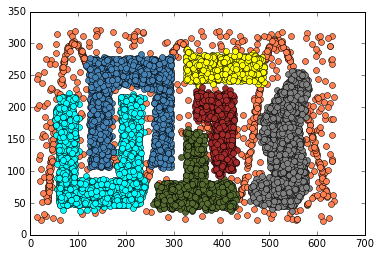

In [314]:
execute_dbscan(10, 20, True, False)